## basics

- llama2: https://github.com/facebookresearch/llama
- rmsnorm: https://github.com/bzhangGo/rmsnorm
    - layernorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
- Swish: SwiLU, SiLU
    - https://arxiv.org/abs/1710.05941v1
    - https://pytorch.org/docs/stable/generated/torch.nn.functional.silu.html
- 参考：
    - https://akgeni.medium.com/llama-concepts-explained-summary-a87f0bd61964

## RMSNorm

- Pre-normalization Using RMSNorm  llama
    - root mean square norm
    - before attn
    - before ffn
    - 相比较 layernorm（re-centering，re-scaling），优化了计算时间；
        - rms norm 只关注 re-scaling

        $$ \begin{align} \begin{split} & \bar{a}_i = \frac{a_i}{\text{RMS}(\mathbf{a})} \odot g_i, \quad \text{where}~~ \text{RMS}(\mathbf{a}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} a_i^2}. \end{split}\nonumber \end{align} $$

    - 我们自然地可以得到一个结论就是，经过 rms norm 之后的 $\bar{\mathbf{a}}$ 其 $\ell_2$ norm 为 $\sqrt n$
       
$$
\|\bar{\mathbf{a}}\|_2=\sqrt{\frac{\sum a_i^2}{\frac1n\sum a_i^2}}=\sqrt{n}
$$
       
```
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
```

In [49]:
import numpy as np
import torch
from torch import nn

In [50]:
bs, seq_len, embedding_dim = 20, 5, 10
x = torch.randn(bs, seq_len, embedding_dim)

### layer norm

In [51]:
ln = nn.LayerNorm(embedding_dim)

In [52]:
x_ln = ln(x)

In [53]:
print(x_ln[1, 3, :].mean())
print(x_ln[1, 2, :].std(unbiased=False))

tensor(5.9605e-08, grad_fn=<MeanBackward0>)
tensor(1.0000, grad_fn=<StdBackward0>)


### RMSNorm

In [54]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [55]:
rms_norm = RMSNorm(embedding_dim)

In [56]:
x_rms = rms_norm(x)

In [57]:
x[0, 0, :]

tensor([-0.3122,  0.9869,  1.8558, -0.2024,  1.5226,  0.3007, -0.2040,  0.7356,
        -0.2018,  0.1626])

In [58]:
x_rms[0, 0, :]

tensor([-0.3578,  1.1309,  2.1267, -0.2320,  1.7448,  0.3445, -0.2338,  0.8430,
        -0.2313,  0.1863], grad_fn=<SliceBackward0>)

In [59]:
x[0, 0, :] / torch.sqrt(torch.sum(x[0, 0, :].pow(2)) / embedding_dim)

tensor([-0.3578,  1.1309,  2.1267, -0.2320,  1.7448,  0.3445, -0.2338,  0.8430,
        -0.2313,  0.1863])

In [60]:
torch.norm(x_rms[0, 0, :])

tensor(3.1623, grad_fn=<LinalgVectorNormBackward0>)

In [61]:
np.sqrt(embedding_dim)

3.1622776601683795

## SwiGLU

- Inspiration of using SwiGLU in LLaMA is taken from PaLM.
- 也叫 SiLU (Sigmoid Linear Unit)，

$$
\text{silu}(x)=x\cdot\sigma(x)=x\cdot\frac{1}{1+\exp(-x)}=\frac{x}{1+\exp(-x)}
$$

In [62]:
def sigmoid(x):
    return  1/(1 + np.exp(-x))

def swish(x):
    return x*sigmoid(x)

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

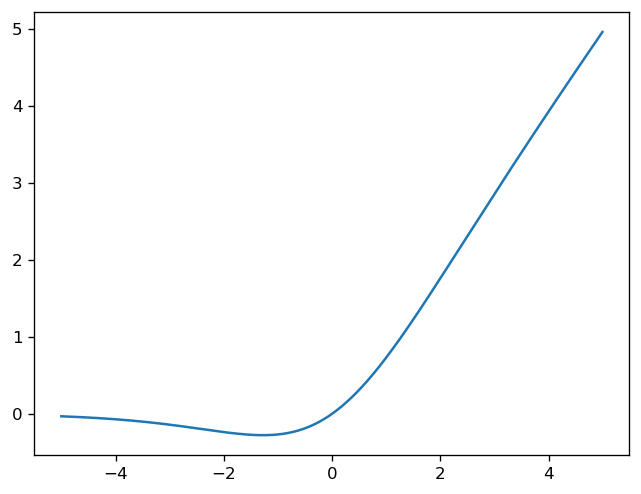

In [64]:
x = np.arange(-5, 5, .01)
plt.plot(x, swish(x))

In [65]:
x = torch.randn(5)
x

tensor([-0.0604, -1.9817,  0.2858,  1.0949,  1.1000])

In [66]:
x/(1+torch.exp(-x))

tensor([-0.0293, -0.2401,  0.1632,  0.8204,  0.8253])

In [40]:
import torch.nn.functional as F

In [67]:
F.silu(x)

tensor([-0.0293, -0.2401,  0.1632,  0.8204,  0.8253])